## Evaluations and Methods for Explanation through Robustness Analysis

###  Setting Config

In [1]:
import os
import sys
import math
import json
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pgd import pgd
from expl_utils import *
from bbmp import bbmp
import matplotlib.pyplot as plt
from skimage import feature, transform


def parse_args():
    parser = argparse.ArgumentParser(description='Example Usage on MNIST')
    parser.add_argument('--gpu', type=int, default=0)
    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--norm', type=int, default=2)
    parser.add_argument('--pgd-eps-start', type=float, default=10.)     
    parser.add_argument('--pgd-niter', type=int, default=100)
    parser.add_argument('--pgd-step-size', type=float, default=1.)
    args, _ = parser.parse_known_args()
    return args

# setting up config
args = parse_args()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(args.gpu)

### Model Preparation

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class UnnormInputModel(nn.Module):
    def __init__(self, model, mean, std):
        super(UnnormInputModel, self).__init__()
        self.model = model
        self.mean = mean
        self.std = std
    
    def forward(self, x):
        x_normed = (x - self.mean) / self.std
        return self.model(x_normed)
    

# prepare model
model = Net()
model.load_state_dict(torch.load('mnist_cnn.pt')) # load pretrained model
model = UnnormInputModel(model, mean=0.1307, std=0.3081)  # wrap the model with a normalization layer
model = model.to(device)
model.eval()

# model sanity check
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor()),
    batch_size=512, shuffle=True)

correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

print('\nTest Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))




Test Accuracy: 9895/10000 (99%)



### Example Input

Predicted Class: 4


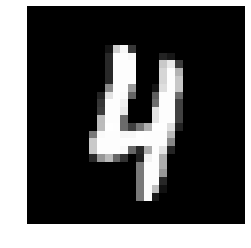

In [3]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

Xs, ys = next(iter(test_loader))
Xs_np = Xs.numpy()
plt.imshow(Xs_np.reshape(28, 28), cmap='gray')
plt.axis('off')

Xs = Xs.to(device)
ys = ys.to(device).long()
assert Xs.shape == (1, 1, 28, 28)
assert ys.shape == (1,)

ys_pred = model(Xs).argmax()
print('Predicted Class:', ys_pred.item())

### Generating Explanations

In [4]:
# Grad
expl_grad = saliency_expl('Grad', Xs, ys, model)
# IG
expl_ig = saliency_expl('IG', Xs, ys, model)
# LOO
expl_loo = saliency_expl('LOO', Xs, ys, model)
# BBMP
expl_bbmp = bbmp(Xs, ys, model, device)
# SHAP
expl_shap = saliency_expl('SHAP', Xs, ys, model)
# Greedy-AS
expl_greedy_as = greedy_as(Xs, ys, model, targeted=False, target=None, norm=args.norm,
                           eps_start=args.pgd_eps_start, step_size=args.pgd_step_size, niters=args.pgd_niter,
                           device=device, reverse_anchor=False)

Computing explanation by Grad...
Computing explanation by IG...
Computing explanation by LOO...
Computing explanation by BBMP...
Computing explanation by SHAP...
Computing explanation by Greedy-AS...
number of relevant features selected: 0.0
number of relevant features selected: 39.0
number of relevant features selected: 78.0
number of relevant features selected: 117.0
number of relevant features selected: 156.0
number of relevant features selected: 195.0
number of relevant features selected: 234.0
number of relevant features selected: 273.0
number of relevant features selected: 312.0
number of relevant features selected: 351.0
number of relevant features selected: 390.0


In [5]:
def visualize(Xs, expls, percentage=15):
    
    def select_top_k(expl):
        expl = np.copy(expl)
        expl += np.random.uniform(-1e-12, 1e-12, size=expl.shape) # for ranking stability
        threshold = np.percentile(expl, 100-percentage)
        top_k_expl = np.copy(expl)
        top_k_expl[expl <= threshold] = 0
        top_k_expl[expl > threshold] = 1
        return top_k_expl
    
    # compute edge for overlay
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, Xs.shape[1], dx)
    yy = np.arange(0.0, Xs.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax    

    Xs = Xs.cpu().reshape(28, 28)

    xi = Xs
    alpha = 0.8
    dilation=3.0
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    # Compute edges (to overlay to heatmaps later)
    xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
    in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
    edges = feature.canny(in_image_upscaled).astype(float)
    edges[edges < 0.5] = np.nan
    edges[:5, :] = np.nan
    edges[-5:, :] = np.nan
    edges[:, :5] = np.nan
    edges[:, -5:] = np.nan
    overlay = edges
 
    # visualize top-k relevant features
    top_k_expls = [select_top_k(expl).reshape(28, 28) for expl in expls]
        
    n_cols = len(expls) + 1
    n_rows = 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

    axes[0].imshow(Xs, cmap='gray')
    axes[0].axis('off')
    for i, expl in enumerate(top_k_expls, 1):
        axes[i].imshow(expl, extent=extent, cmap='Reds', vmin=0, vmax=1)
        axes[i].imshow(overlay, extent=extent, cmap=cmap_xi, alpha=alpha)
        axes[i].axis('off')



/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


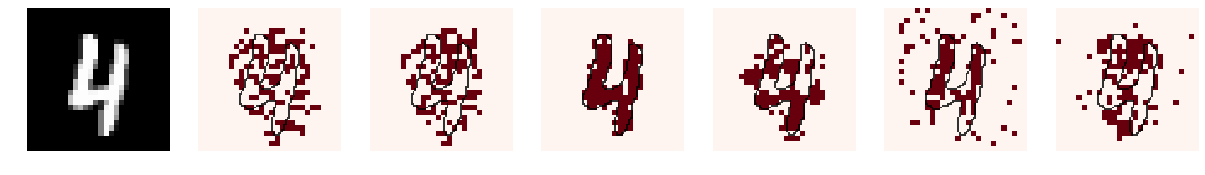

In [6]:
visualize(Xs, [expl_grad, expl_ig, expl_loo, expl_bbmp, expl_shap, expl_greedy_as])

### Evaluating Explanations through Robustness Analysis

In [7]:
def eval_curve_robust(Xs, ys, model, targeted, targets, norm, eps_start, step_size, niters, expl,
                      device, reverse_anchor):
    # set up logger
    logger = list()
    
    # for topk stability
    expl = np.copy(expl)
    expl += np.random.uniform(-1e-12, 1e-12, size=expl.shape)
    
    for i in range(0, 50, 5):
        threshold = np.percentile(expl, 100 - i)
        top_k_expl = np.copy(expl)
        top_k_expl[expl <= threshold] = 0
        top_k_expl[expl > threshold] = 1
        anchor_map = top_k_expl
        if reverse_anchor:
            anchor_map = np.logical_not(anchor_map)
        anchor_map = torch.BoolTensor(anchor_map).to(device)
        
        def binary_search_cond(Xs, ys, epsilons, anchor_map, targeted, targets):
            epsilons = torch.FloatTensor(epsilons).to(device)
            successes, Xs_pgd = pgd(Xs, ys, model, epsilons, norm, niters, step_size, anchor_map, targeted, targets=targets,
                                    box_min=0., box_max=1., verbose=False, multi_start=True, device=device)
            return successes, Xs_pgd
        
        robust_ub, Xs_pgd = binary_search(binary_search_cond, Xs, ys, np.full(len(Xs), eps_start), anchor_map, targeted, targets, tol=0.001, max_steps=25)
        robust_ub = robust_ub[0]
        logger.append(robust_ub)
        print('robustness:', robust_ub)

    return logger
    

In [8]:
eval_curve_grad = eval_curve_robust(Xs, ys, model, False, None, args.norm, args.pgd_eps_start,
                                    args.pgd_step_size, args.pgd_niter, expl_grad, device, False)
eval_curve_greedy_as = eval_curve_robust(Xs, ys, model, False, None, args.norm, args.pgd_eps_start,
                                        args.pgd_step_size, args.pgd_niter, expl_greedy_as, device, False)

robustness: 1.2032470703125
robustness: 1.58062744140625
robustness: 1.6427001953125
robustness: 1.88165283203125
robustness: 2.0491943359375
robustness: 2.0843505859375
robustness: 2.52105712890625
robustness: 2.6435546875
robustness: 2.77099609375
robustness: 2.79296875
robustness: 1.2021484375
robustness: 1.7119140625
robustness: 2.0426025390625
robustness: 2.3271484375
robustness: 2.8402099609375
robustness: 3.0775146484375
robustness: 3.8970947265625
robustness: 4.44586181640625
robustness: 4.9495849609375
robustness: 5.392333984375


Text(0.5, 0, 'Percentage of Relevant Features (|$S_r$|/d)')

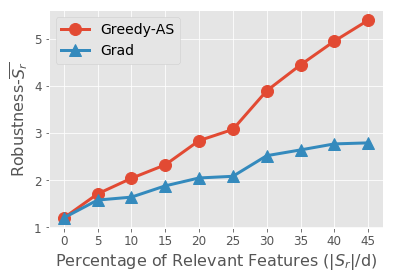

In [9]:
plt.style.use('ggplot')
markers = ['o', '^']
fig = plt.figure()
ax = plt.axes()

methods = ['Greedy-AS', 'Grad']
curves = [eval_curve_greedy_as, eval_curve_grad]

for i, (method, curve) in enumerate(zip(methods, curves)):
    steps = len(curve)
    ax.plot(np.arange(steps), curve, label=method, linewidth=3, marker=markers[i], markersize=12)


leg = plt.legend(framealpha = 1, loc = 2, fontsize=14)
for text in leg.get_texts():
    plt.setp(text, color='black')

plt.xticks(np.arange(10), np.arange(10)*5)
plt.tick_params(labelsize=12)
plt.ylabel(r'Robustness-$\overline{S_r}$', fontsize=16)
plt.xlabel(r'Percentage of Relevant Features (|$S_r$|/d)', fontsize=16)